# Analysis of the greedy algorithms

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List, Iterable

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
# results_filename = "../data/greedy_caroline_40.json"
results_filename = "../data/greedy_paper_r_t40_s8_dt07-14_15-06-16.json"

with open(results_filename) as file:
    results_data = json.load(file)

In [3]:
algorithm_results = {}
for model_results in results_data:
    for algorithm, algorithm_result in model_results.items():
        if algorithm == 'model' or 'Deadline Percent' in algorithm:
            continue
        if algorithm in algorithm_results:
            algorithm_results[algorithm].append(algorithm_result)
        else:
            algorithm_results[algorithm] = [algorithm_result]
    
print(f'Number of algorithms: {len(algorithm_results)}')

Number of algorithms: 21


## Greedy modular functions

In [4]:
algorithm_avg_results = [
    [
        algorithm,
        [r['social welfare'] for r in results], 
        [r['social welfare percent'] for r in results], 
        [r['percentage tasks allocated'] for r in results], 
        [np.mean(list(r['server storage used'].values())) for r in results],
        [np.mean(list(r['server computation used'].values())) for r in results],
        [np.mean(list(r['server bandwidth used'].values())) for r in results],
        [np.mean(list(r['server num tasks allocated'].values())) for r in results],
        np.mean([r['social welfare'] for r in results])
    ]
    for algorithm, results in algorithm_results.items()
]

algorithm_df = pd.DataFrame(algorithm_avg_results, columns=[
    'name', 'social welfare', 'social welfare percent', 'percentage tasks allocated', 
    'storage used',  'computation used', 'bandwidth used', 'num tasks allocated', 'avg social welfare'
])
algorithm_df = algorithm_df.sort_values(by='avg social welfare')

Text(0.5, 1.0, 'Percentage Tasks Allocated')

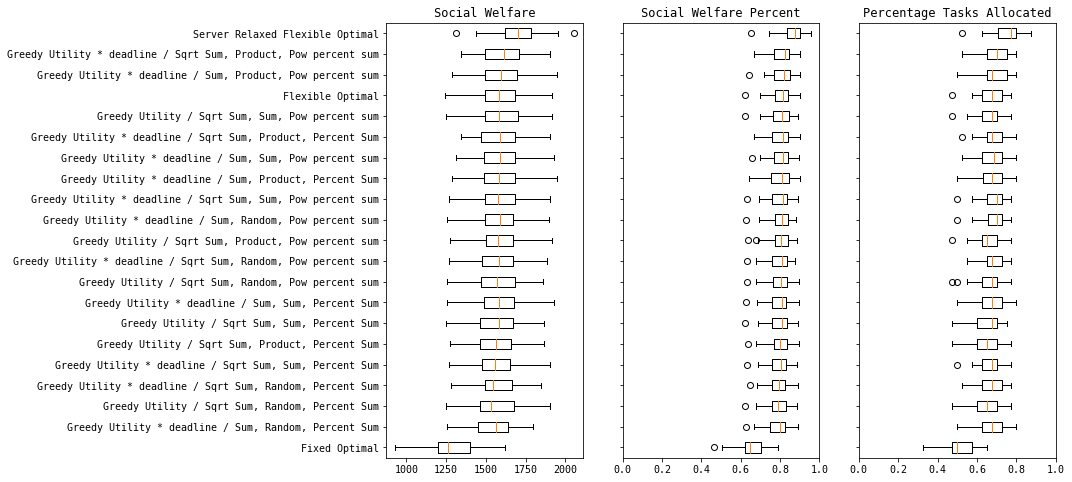

In [5]:
system_fig, (ax_sw, ax_swp, ax_pta) = plt.subplots(1, 3, figsize=(12, 8))
ax_sw.boxplot(algorithm_df['social welfare'], vert=False)
ax_sw.set_yticklabels(algorithm_df['name'])
ax_sw.set_title('Social Welfare')

ax_swp.boxplot(algorithm_df['social welfare percent'], vert=False)
plt.setp(ax_swp.get_yticklabels(), visible=False)
ax_swp.set_xticks(np.arange(0, 1.2, 0.2))
ax_swp.set_title('Social Welfare Percent')

ax_pta.boxplot(algorithm_df['percentage tasks allocated'], vert=False)
plt.setp(ax_pta.get_yticklabels(), visible=False)
ax_pta.set_xticks(np.arange(0, 1.2, 0.2))
ax_pta.set_title('Percentage Tasks Allocated')

Text(0.5, 1.0, 'Bandwidth Used')

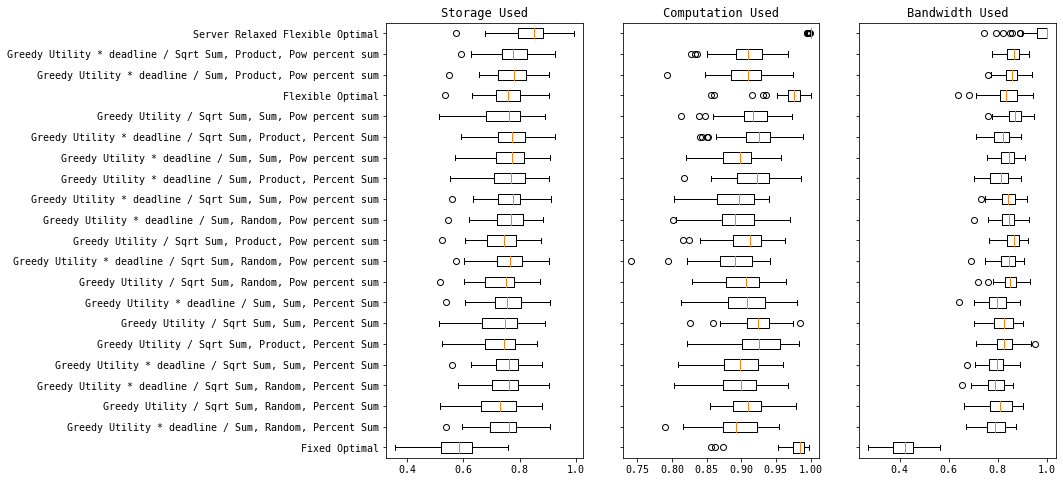

In [6]:
server_fig, (ax_storage_used, ax_computation_used, ax_bandwidth_used) = plt.subplots(1, 3, figsize=(12, 8))
ax_storage_used.boxplot(algorithm_df['storage used'], vert=False)
ax_storage_used.set_yticklabels(algorithm_df['name'])
ax_storage_used.set_title('Storage Used')

ax_computation_used.boxplot(algorithm_df['computation used'], vert=False)
plt.setp(ax_computation_used.get_yticklabels(), visible=False)
ax_computation_used.set_title('Computation Used')

ax_bandwidth_used.boxplot(algorithm_df['bandwidth used'], vert=False)
plt.setp(ax_bandwidth_used.get_yticklabels(), visible=False)
ax_bandwidth_used.set_title('Bandwidth Used')

## Percentage difference in algorithm results and optimal solutions

In [7]:
def difference(results_1, results_2):
    sw = []
    for r1, r2 in zip(results_1, results_2):
        sw.append(r1['social welfare'] / r2['social welfare'])
    return np.mean(sw),  sw

optimal_algorithm_results = algorithm_results['Flexible Optimal']
fixed_optimal_algorithm_results = algorithm_results['Fixed Optimal']
relaxed_optimal_algorithm_results = algorithm_results['Server Relaxed Flexible Optimal']
algorithm_difference_results = [
    [algorithm, 
     *difference(results, optimal_algorithm_results), 
     *difference(results, fixed_optimal_algorithm_results),
     *difference(results, relaxed_optimal_algorithm_results)]
    for algorithm, results in algorithm_results.items()
]

algo_diff_df = pd.DataFrame(algorithm_difference_results, columns=[
    'name', 'optimal sw diff', 'optimal sw diff list',
    'fixed optimal sw diff', 'fixed optimal sw diff list',
    'relaxed optimal sw diff', 'relaxed optimal sw diff list'
])
algo_diff_df = algo_diff_df.sort_values(by='optimal sw diff', ascending=False)

Text(0.5, 1.0, 'Difference to Relaxed Optimal')

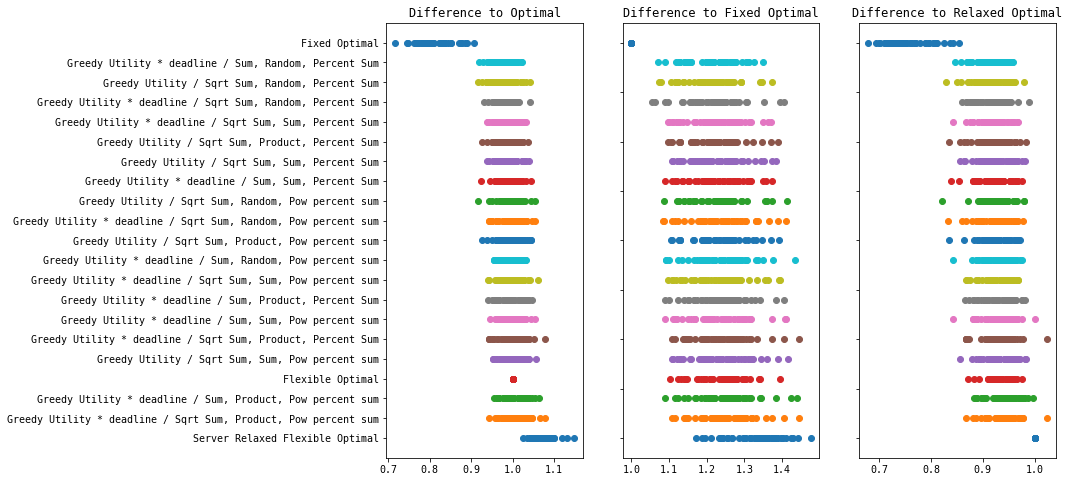

In [8]:
diff_fig, (ax_optimal_sw_points, fixed_optimal_sw_points, relaxed_optimal_sw_points) = plt.subplots(1, 3, figsize=(12,8))
for pos, (optimal_list, fixed_list, relaxed_list) in enumerate(
    algo_diff_df[['optimal sw diff list', 'fixed optimal sw diff list', 'relaxed optimal sw diff list']].values):
    ax_optimal_sw_points.scatter(optimal_list, np.ones(len(optimal_list)) * pos)
    fixed_optimal_sw_points.scatter(fixed_list, np.ones(len(fixed_list)) * pos)
    relaxed_optimal_sw_points.scatter(relaxed_list, np.ones(len(fixed_list)) * pos)

ax_optimal_sw_points.set_yticks(np.arange(len(algo_diff_df['name'])))
ax_optimal_sw_points.set_yticklabels(algo_diff_df['name'], minor=False)
ax_optimal_sw_points.set_title('Difference to Optimal')

plt.setp(fixed_optimal_sw_points.get_yticklabels(), visible=False)
fixed_optimal_sw_points.set_title('Difference to Fixed Optimal')

plt.setp(relaxed_optimal_sw_points.get_yticklabels(), visible=False)
relaxed_optimal_sw_points.set_title('Difference to Relaxed Optimal')

## Overall results

Greedy algorithm: Greedy Utility * deadline / Sum, Product, Pow percent sum

Data length: 20
Save file location: figs/greedy/eps/greedy_algorithms.eps
Save file location: figs/greedy/png/greedy_algorithms.png
Save file location: figs/greedy/pdf/greedy_algorithms.pdf


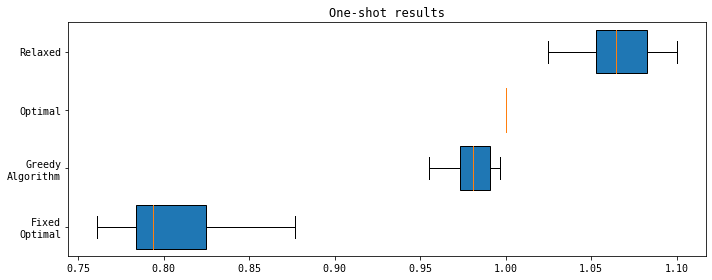

In [9]:
greedy_algos_df = algorithm_df[algorithm_df['name'].str.contains('Greedy')]
greedy_algo = algorithm_df.iloc[greedy_algos_df['avg social welfare'].idxmax()]['name']
print(f'Greedy algorithm: {greedy_algo}\n')

data = [[], [], [], []]
for greedy_result, optimal_result, fixed_result, relaxed_result in zip(
    algorithm_results[greedy_algo], algorithm_results['Flexible Optimal'], 
    algorithm_results['Fixed Optimal'], algorithm_results['Server Relaxed Flexible Optimal']):
    if greedy_result['social welfare'] <= optimal_result['social welfare'] and greedy_result['social welfare'] <= relaxed_result['social welfare']:
        data[2].append(1)
        data[0].append(fixed_result['social welfare'] / optimal_result['social welfare'])
        data[3].append(relaxed_result['social welfare'] / optimal_result['social welfare'])
        data[1].append(greedy_result['social welfare'] / optimal_result['social welfare'])
print(f'Data length: {len(data[0])}')

fig, ax_boxplot = plt.subplots(figsize=(10, 4))
ax_boxplot.boxplot(data, vert=False, patch_artist=True, widths=0.75)
ax_boxplot.set_yticklabels(['Fixed\nOptimal', 'Greedy\nAlgorithm', 'Optimal', 'Relaxed'])
ax_boxplot.set_title('One-shot results')
plt.tight_layout()
save_plot('greedy_algorithms', 'greedy')